# **Enter deaths-per-day data**

In [ ]:
#please, enter data below between the ''' (triple quotes)
ENTER_DATA = '''
Example:                Days  : 1   2   3   4   5 ... (this line can be ommited)
    Canton S Male Spring 2012 : 0	0	0	1	0	0	0	1	2	3	1	2	1	0	0	0	2	0	2	0	1	0	2	4	5	1	2	4	4	0	1	3	0	0	1	3	2	6	5	1	5	0	0	0	2	0	1	2	2	2	4	13	11	21	8	4	4	1	3	3	8	4	1	3	3	5	3	6	4	8	0	3	1	1	0	1
    Canton S Female Spring 2012 : 0	0	0	0	1	0	0	1	0	1	0	1	0	0	3	0	0	1	0	2	0	3	0	0	1	0	0	2	0	0	0	1	0	0	1	1	1	1	1	1	0	0	2	3	4	2	4	3	6	3	3	6	0	2	1	3	2	5	6	3	4	0	6	3	2	6	4	7	7	3	5	6	3	5	2	11 2	0	2	0	0	1	1	1	0	0	0	1
'''


#or upload a file in the same folder as script and write the name of your file
#please use .xml format
FILE_NAME = 'Example data for calculations using the Python script.xml'


#enter the names of the samples which you want to compare
WHAT_TO_COMPARE = '''
Canton S Male Spring 2012,                 Canton S Female Spring 2012
'''

#FOR CUSTOM GRAPHS PLEASE CHECK THE "ADVANCED SETTINGS" CELL

# **Initiate Supplementary functions**

In [ ]:
import math
from scipy.stats import norm #, kurtosis
from scipy import stats
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, LogLocator, PercentFormatter, AutoMinorLocator
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.patches import Patch
from scipy.special import gamma
from scipy import ndimage

class Statistic_result:

    p_eval = lambda p: '<0.0001' if p < 0.0001 else '<0.001' if p < 0.001 else '<0.01' if p < 0.01 else '<0.05' if p < 0.05 else '>0.05'

    def __init__(self, statistics_name, W, P):
        self.statistics_name = statistics_name
        self.W = W
        self.P = P
        self.result = self.result__

    def result__(self, numeric=True, binary=False):
        if numeric:
            return (self.W, self.P)
        if binary:
            if self.P < .05:
              return 0
            return 1
        return f'W={round(self.W, 2)};\np{Statistic_result.p_eval(self.P)}; '

#create Beta distribution
beta_function = lambda α, β: gamma(α)*gamma(β)/gamma(α+β)
betaPDF = lambda α, β, x: x**(α-1)*(1-x)**(β-1)/beta_function(α, β)
alpha_mode = lambda μ, mode: (1-2*mode)/(1-mode/μ)
beta_mode = lambda μ, mode: (2*mode-2*mode*μ-1+μ)/(mode-μ)
alpha_median = lambda μ, median: 1/3*(1-2*median)/(1-median/μ)
beta_median  = lambda μ, median: 1/3*(μ-1)*(1-2*median)/(median-μ)
execute_double = lambda func1, func2, *args: (func1(*args), func2(*args))
#Sturges formula
STURGES = lambda n: 1+math.log(n, 2)
#mode function for dpd
MODE    = lambda dpd: dpd.index(max(dpd))

# **Functions for data preparation**

In [ ]:
define_sp = lambda dlt, rng=15, crnt=[-1]: crnt[1:] if len(crnt) == rng else define_sp(dlt, rng, crnt+[crnt[-1]+dlt])

cut_first_zero = lambda l:  cut_first_zero(l[1:]) if l[0] == 0 else l

conclusion = lambda p: 'norm with alpha = 0.05' if p > .05 else 'not norm with alpha = 0.05'

format_p = lambda p: '<0.001' if p < .001 else f"{p:.3f}"

#Pearson
Pearson_ = lambda x, y: round((len(x)*sum(x*y) - sum(x)*sum(y))/(((len(x)*sum(x**2)-sum(x)**2)*(len(y)*sum(y**2)-sum(y)**2))**(0.5)), 2)

#Function for trimming zeros at the start of multiple intervalised samples.
def cut_first_zero_multiple(samples):
    samples_ = np.vstack(samples)
    col_all_zero = np.all(samples_ == 0, axis=0)
    non_zero_cols = np.where(~col_all_zero)[0]
    start = non_zero_cols[0]

    trimmed = samples_[:, start:]
    return [row for row in trimmed]


#Function for partitioning LifeSpan data into intervals
def Sample_to_intervals(sample, delta=0.0, interv=0.0, i=0):
    sti = lambda s, d, i, f=[0]: f if len(s)==0 else sti(s[1:], d, i, f[:-1]+[f[-1]+1]) if s[0] <= i+d else sti(s, d, i+d, f+[0])
    if interv == 0:
      interv = 1+math.log(len(sample), 2)
    if delta == 0:
      delta = (max(sample)-i)/interv

    result = sti(sample, delta, i=i)
    return result

#Function for prepairing two LifeSpan data samples for comparison analysis
def group_two(ls1, ls2, delta=5, i=-1):
    s1 = Sample_to_intervals(ls1, delta=delta, i=i)
    s2 = Sample_to_intervals(ls2, delta=delta, i=i)
    diff = len(s2) - len(s1)
    if diff > 0:
      s1.extend([0] * diff)
    elif diff < 0:
      s2.extend([0] * (-diff))
    return s1, s2

#Function for creation of death curve data from Deaths-per-day data sample
def death_curve(deaths):
    n = sum(deaths)
    out = [1 - deaths[0]/n]
    for i in range(1, len(deaths)):
      out.append(round((out[i-1] - (deaths[i]/n)), 3))
    return out

# Function for prepairing two Deaths-per-day data samples for comparison analysis
def group_two_sub(g1, g2):
    l1 = death_curve(g1)
    l2 = death_curve(g2)
    while len(l1) < len(l2):
      l1.append(0.0)
    while len(l1) > len(l2):
      l2.append(0.0)
    return l1, l2

# Function for conversion of Deaths-per-day (DPD) data into LifeSpan (LS) data
# put in max_data_length if you want to print the data and then import it somethere else
def convert_deaths_per_day_to_lifespan(dataset:dict, max_data_length=0)->dict:
    dataset = dataset.copy()
    for data in dataset:
        days = list(range(0, len(dataset[data])+1))  #0 is for the row with the first 0
        deaths_per_day = list(zip(dataset[data], days))
        if max_data_length:
            dataset[data] = [str(i[1]) for i in deaths_per_day for j in range(0, int(i[0]))]
            if len(dataset[data]) < max_data_length:
                dataset[data] = dataset[data] + ['_' for i in range(max_data_length - len(dataset[data]))]
        else:
            dataset[data] = [float(i[1]) for i in deaths_per_day for j in range(0, int(i[0]))]
    if max_data_length:
        output = list(zip(*[dataset[i] for i in dataset]))
        title = [j for j in dataset]
        print(','.join(title))
        for i in output:
            print(','.join(i))
        return dict()
    return dataset

# Function for conversion of intervalized data into pseudo-DPD data.
def RECREATE_CURRENT_DATA(sample, delta=5, initial_day=-1)->list:
    out = []
    day = initial_day
    for m in sample:
        day += delta
        for i in range(int(m)):
            out.append(day - delta)
    return out

# **Searching for coefficient K**

In [ ]:
def create_ideal_normal_row(sample_size:int, start:int, finish:int)->np.array:
    find_k = lambda n, ε: np.log(n)/(-np.log(1/np.pi*0.75))+1.382+ε
    norm_inv_first = norm.ppf(1/(sample_size+1))
    norm_inv_last = norm.ppf(sample_size/(sample_size+1))
    delta = finish-start
    create_ideal_row = lambda σ, µ: np.round(
        norm.ppf(
            np.array(
                [i/(sample_size+1) for i in range(1, sample_size+1)]
                ))*σ+µ, 0)
    def find_σ_and_µ(ε)->tuple:
        find_µ = lambda cdf_inv, n1, σ: n1-cdf_inv*σ
        σ = delta/find_k(sample_size, ε)
        µ = find_µ(norm_inv_first, start, σ)
        if (np.round(norm_inv_first*σ+µ, 0) == start) and (np.round(norm_inv_last*σ+µ, 0) == finish):
            return σ, µ
        return False, False
    σ, µ = find_σ_and_µ(0)
    if σ == False:
        sign = 1
        if sample_size > 5169:
            sign = -2.48
        elif sample_size > 4121:
            sign = -2.2
        elif sample_size > 3641:
            sign = -2
        elif sample_size > 3000:
            sign = -1.8
        elif sample_size > 2627:
            sign = -1.5
        elif sample_size > 2128:
            sign = -1.3
        elif sample_size > 925:
            sign = -1
        if sample_size < 42:
            sign = -1
            if finish-start > 97:
                sign = -1.25
        if sample_size < 22:
            sign = -1.5
            if finish-start > 139:
                sign = -2
        if sample_size < 18:
            sign = -2.5
            if finish-start > 83:
                sign = -3
        if sample_size < 12:
            sign = -4
        if sample_size < 8:
            sign = -6
        if sample_size < 5:
            sign = -10
            if finish-start > 244:
                sign = -9
        if sample_size == 2:
            if finish-start > 120:
                sign = -15
            else:
                sign = -12
        for correction in range(1, 100, 1):
            σ, µ = find_σ_and_µ(correction*sign/1000)
            if σ == False:
                continue
            return create_ideal_row(σ, µ)
        raise ValueError('Could not find σ with N='+str(sample_size)+' start='+str(finish)+' end='+str(sign))
    return create_ideal_row(σ, µ)

# **Parsing inputed data**

In [ ]:
from pathlib import Path

new_file_path = Path('./'+FILE_NAME)
if new_file_path.exists() and new_file_path.is_file():
    ENTER_DATA = new_file_path.read_text()
else:
    print(FILE_NAME+' not found, using data from input')
raw_data = dict()
genotype_names = []
splitter = None

#.xml line parser
if '.xml' in FILE_NAME.lower():
    data_sheets = ENTER_DATA.split('<Worksheet ss:')[1:]
    for data_sheet in data_sheets:
      name = data_sheet[6:data_sheet.index('">')]
      print(name)
      genotype_names.append(name)
      genotypes = data_sheet.split('<Row')[1:]
      for genotype in genotypes:
          if not ('day' in genotype.lower()):
              genotype = genotype.split('</Data></Cell>')
              geno = ' '.join(genotype[0].split('>')[-1].split())
              if geno:
                data = []
                for cell in genotype[1:-1]:
                    try:
                        data.append(int(cell.split('>')[-1]))
                    except:
                        continue
                raw_data[name.lower()+'\n'+geno] = np.array(data)

if '.txt' in FILE_NAME.lower():
    splitter = None
elif '.csv' in FILE_NAME.lower():
    if ',' in ENTER_DATA:
        splitter = ','
    elif ';' in ENTER_DATA:
        splitter = ';'
    else:
        splitter = None

if len(raw_data) == 0:
    print('parsing ENTER_DATA')
    genotype_names = ["Genotype"]
    Dataset_for_analysis = ENTER_DATA
    s1 = [s.split(':') for s in Dataset_for_analysis.split('\n') if s and not ('day' in s.lower())]
    raw_data = dict(map(lambda s : ('genotype\n' + ' '.join(s[0].split()), np.array([int(i) for i in s[1].split(splitter)])), s1))
ls_data = convert_deaths_per_day_to_lifespan(raw_data)
ideal_normal_data = dict()
for geno in ls_data:
  data = ls_data[geno]
  ideal_normal_data[geno] = create_ideal_normal_row(len(data),
                                                    data[0],
                                                    data[-1])

Example data for calculations using the Python script.xml not found, using data from input
parsing ENTER_DATA


# **Shapiro-Wilk test**

In [ ]:
table_for_a = {
    '6' : [.6431, .2806, .0875],
    '7' : [.6233, .3031, .1401],
    '8' : [.6052, .3164, .1743, .0561],
    '9' : [.5888, .3244, .1976, .0947],
    '10': [.5739, .3291, .2141, .1224, .0399],
    '11': [.5601, .3315, .2260, .1429, .0695],
    '12': [.5475, .3325, .2347, .1586, .0922, .0303],
    '13': [.5359, .3325, .2412, .1707, .1099, .0539],
    '14': [.5251, .3318, .2460, .1802, .1240, .0727, .0240],
    '15': [.5150, .3306, .2495, .1878, .1353, .0880, .0433],
    '16': [.5056, .3290, .2521, .1939, .1447, .1005, .0593, .0196],
    '17': [.4968, .3273, .2540, .1988, .1524, .1109, .0725, .0359],
    '18': [.4886, .3253, .2553, .2027, .1587, .1197, .0837, .0496, .0163],
    '19': [.4808, .3232, .2561, .2059, .1641, .1271, .0932, .0621, .0303],
    '20': [.4734, .3211, .2565, .2085, .1686, .1334, .1031, .0711, .0422, .0140],
    '21': [.4643, .3185, .2578, .2119, .1736, .1399, .1092, .0804, .0530, .0263],
    '22': [.4590, .3156, .2571, .2131, .1764, .1443, .1150, .0878, .0618, .0368, .0122]
}

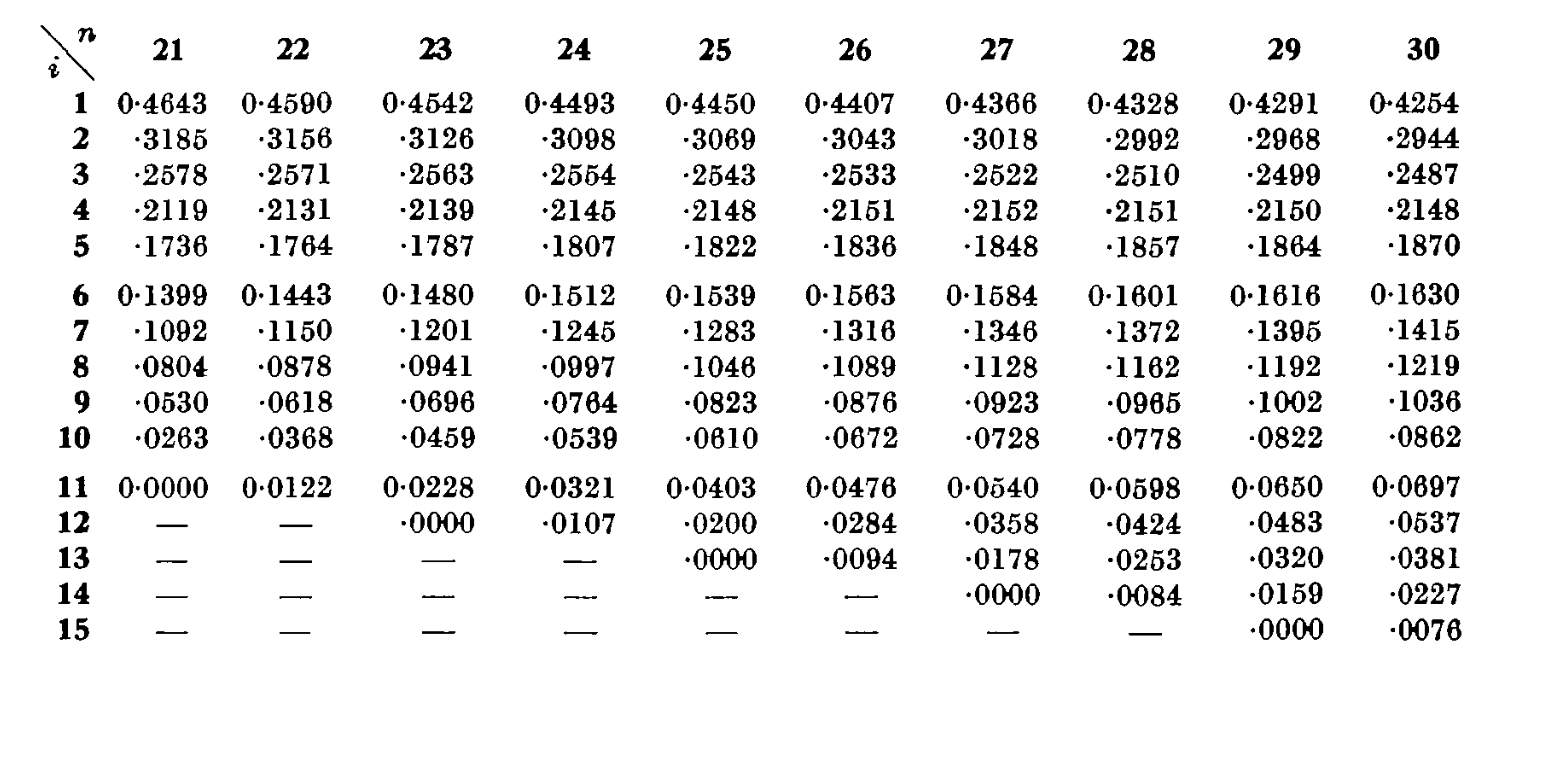

In [ ]:
find_m = lambda n: int(n/2) if n%2==0 else int((n-1)/2)
def Shapiro_Wilk_normality_test(sample, a):
  sample.sort()
  n = len(sample)
  av = sum(sample)/float(len(sample))
  SS = sum((x-av)**2 for x in sample)
  m = find_m(len(sample))
  b = sum(map(lambda ai, xi, xn_i: ai*(xn_i - xi),  a, sample[:m], sample[:m:-1]))
  W = b**2/SS
  µ = 0.0038915*(math.log(n)**3)-0.083751*(math.log(n)**2)-0.31082*math.log(n)-1.5861
  sd = math.exp(.0030302*(math.log(n)**2)-.082676*(math.log(n))-.4803)
  z = (math.log(1-W)-µ)/sd
  p_val = 1-norm.cdf(z)
  return Statistic_result('SW_test', W, p_val)

In [ ]:
def Shapiro_Wilk_normality_test_Royston(sample):
  sample.sort()
  n = len(sample)
  av = sum(sample)/float(len(sample))
  m = [norm.ppf((i-.375)/(n+.25)) for i in range(1, len(sample)+1)]
  mm = sum(i**2 for i in m)
  u = 1/math.sqrt(n)
  a = []
  a.append(-3.582633*(u**5)+5.682633*(u**4)-1.752461*(u**3)-0.293762*(u**2)+0.042981*u+m[-2]/math.sqrt(mm))
  a.append(-2.706056*(u**5)+4.434685*(u**4)-2.07119*(u**3)-0.147981*(u**2)+0.221157*u+m[-1]/math.sqrt(mm))
  a = [-a[-1]]+[-a[-2]]+a
  e = (mm-2*(m[-1]**2)-2*(m[-2]**2))/(1-2*(a[-1]**2)-2*(a[-2]**2))
  a = a[:2]+[i/math.sqrt(e) for i in m[2:-2]]+a[-2:]
  W = sum(map(lambda ai, xi: ai*xi, a, sample))**2/sum(map(lambda xi: (xi - av)**2, sample))
  if n < 12:
    µ = -0.0006714*(n**3)+0.025054*(n**2)-0.39978*n-.5440
    sd = math.exp(-0.0020322*(n**3)+0.062767*(n**2)-0.77857*n+1.3822)
    γ = 0.0459*n-2.273
    z = (-math.log(γ-math.log(1-W))-µ)/sd
  else:
    µ = 0.0038915*(math.log(n)**3)-0.083751*(math.log(n)**2)-0.31082*math.log(n)-1.5861
    sd = math.exp(.0030302*(math.log(n)**2)-.082676*(math.log(n))-.4803)
    z = (math.log(1-W)-µ)/sd
  p_val = 1-norm.cdf(z)
  return Statistic_result('SW_test', W, p_val)

In [ ]:
#One sample KS test
Kolmagorov_1933 = lambda d, n: 1-(1-2*sum([(-1)**(k-1)*np.exp(-2*(k**2)*(d*d*np.sqrt(n)**2)) for k in range(1, 90)]))
def one_sample_KS_test(sample, asim=True):
  sample.sort()
  n = len(sample)
  rank_positive = np.array(range(n))/n
  rank_negative = np.array(range(1, n+1))/n
  sample_cdf = norm.cdf(sample, loc=np.mean(sample), scale=np.std(sample))
  D_stat_positive = max(np.absolute(sample_cdf-rank_positive))
  D_stat_negative = max(np.absolute(sample_cdf-rank_negative))
  if asim: #n > 51:
    p_value = 2*np.exp(-(2.000071+0.331/(n**0.5)+1.409/n)*n*(max(D_stat_positive, D_stat_negative)**2))
  else:
    p_value = Kolmagorov_1933(max(D_stat_positive, D_stat_negative), n)
  result = Statistic_result('One sample ks test', max(D_stat_positive, D_stat_negative), p_value)
  result.D_stat_positive = D_stat_positive
  result.D_stat_negative = D_stat_negative
  return result

# **All plots with plots inside of them**

In [ ]:
parse_sample_names = lambda prompt: [' '.join(i.split()) for i in prompt.split('\n') if i and len(i)>3] if '\n' in prompt else ValueError('Genotype names are entered incorrectly')
SAMPLES = parse_sample_names(WHAT_TO_COMPARE)
if len(SAMPLES) == 0:
    SAMPLES = list(ls_data.keys())
FILE_NAME = FILE_NAME.split('.')[0]
print(SAMPLES, FILE_NAME)

['Canton S Male Spring 2012, Canton S Female Spring 2012'] Example data for calculations using the Python script


In [ ]:
alias = lambda input: '$\it{white}$'.join(input.split('white'))

<>:1: SyntaxWarning: invalid escape sequence '\i'
<>:1: SyntaxWarning: invalid escape sequence '\i'
/tmp/ipython-input-1536194770.py:1: SyntaxWarning: invalid escape sequence '\i'
  alias = lambda input: '$\it{white}$'.join(input.split('white'))


In [ ]:
def find_p_q(min_, max_, mean_, mode_=0, median_=0, method="TREE")->tuple:
    VERIFY_PQ = lambda p, q: True if (p >= 1) and (q >= 1) else False

    mean_down_scaled   = (mean_-min_)/(max_-min_)
    mean_down_scaled_for_median = 1 - mean_down_scaled
    mode_down_scaled   = (mode_-min_)/(max_-min_)
    median_down_scaled = 1 - (median_-min_)/(max_-min_)


    if method in ("MODE", "TREE") and mean_down_scaled < 0.5:
        if mode_down_scaled < mean_down_scaled:
            p, q = execute_double(alpha_mode, beta_mode, mean_down_scaled, mode_down_scaled)
            if VERIFY_PQ(p, q):
                label = f'Mode({np.round(mode_down_scaled, 2):.2f})<µ({np.round(mean_down_scaled, 2):.2f})'
                return p, q, label

    elif method in ("MODE", "TREE") and mode_down_scaled > mean_down_scaled:
            p, q = execute_double(alpha_mode, beta_mode, mean_down_scaled, mode_down_scaled)
            if VERIFY_PQ(p, q):
                label = f'Mode({np.round(mode_down_scaled, 2):.2f})>µ({np.round(mean_down_scaled, 2):.2f})'
                return p, q, label

    if method in ("MEDIAN", "TREE") and mean_down_scaled_for_median < 0.5:
        if median_down_scaled < mean_down_scaled_for_median:
            q, p = execute_double(alpha_median, beta_median, mean_down_scaled_for_median, median_down_scaled)
            if VERIFY_PQ(p, q):
                label = f'Median({np.round(median_down_scaled, 2):.2f})<µ({np.round(mean_down_scaled_for_median, 2):.2f})'
                return p, q, label

    elif method in ("MEDIAN", "TREE") and median_down_scaled > mean_down_scaled_for_median:
            q, p = execute_double(alpha_median, beta_median, mean_down_scaled_for_median, median_down_scaled)
            if VERIFY_PQ(p, q):
                label = f'Median({np.round(median_down_scaled, 2):.2f})>µ({np.round(mean_down_scaled_for_median, 2):.2f})'
                return p, q, label

    return 3.5, 3.5, "Bell-shaped"

# **Code for making final graphs**

In [ ]:
#base config & function for making configs from the base one
def base_config():
    return {
        "show": {
            "bars": True,
            "sub": True,
            "legend": True,
        },
        "lines": {
            "type": None
        },
        "methods": {
            "mod_or_median": ["TREE", "TREE"],
            "Intervalisation_mode": ["AUTO", "AUTO"],
            "Initial_day": [0, 0],
            "Ideal_curve_line": [0, 0],
            "beta_step": (1/3)
        },
    }

def make_config(*, show=None, lines=None, methods=None):
    cfg = base_config()
    if show:
        cfg["show"].update(show)
    if lines:
        cfg["lines"].update(lines)
    if methods:
        cfg["methods"].update(methods)
    return cfg

#default graph modes
def default_settings():

    m1 = make_config(show={"legend": False})      # no SW, no lines, only bars+sub
    m2 = make_config()                            # base (bars+sub+SW), no lines
    m3 = make_config(lines={"type": "normal"})    # normal distribution (normal/normal lines + bars + sub + SW)
    m4 = make_config(lines={"type": "beta"})      # beta distribution (beta/beta lines + bars + sub + SW)
    m5c = make_config(lines={"type": "ideal"})    # normal control/ideal normal control (normal/ideal normal lines + bars + sub + SW)
    m5m = make_config(                            # same as m5c but for mutant
        lines={"type": "ideal"},
        methods={"Ideal_curve_line": [1, 1]}
    )

    return [m1, m2, m3, m4, m5c, m5m]


In [ ]:
#function for drawing graphs

def FIND_START(m, i=0):
    for idx, value in enumerate(m[i:], start=i):
        if value != 0:
            return idx
    return None

def FIND_END(m):
    for idx in range(len(m) - 1, -1, -1):
        if m[idx] != 0:
            return idx
    return None

def prepare_pair_data(allele, pair, ls_data, raw_data):
    control, mutant = pair.split(', ')
    key_c = allele.lower() + '\n' + control
    key_m = allele.lower() + '\n' + mutant

    ctrl_dpd = raw_data[key_c]
    mut_dpd = raw_data[key_m]
    ctrl_ls = ls_data[key_c]
    mut_ls  = ls_data[key_m]


    #intervalised lifespan data
    A, B = group_two(ctrl_ls, mut_ls, delta, i=-1)
    A_pct = [x/sum(A)*100 for x in A]
    B_pct = [x/sum(B)*100 for x in B]

    #survival curves
    A_sub, B_sub = group_two_sub(raw_data[key_c], raw_data[key_m])
    A_sub = [x*100 for x in A_sub]
    B_sub = [x*100 for x in B_sub]

    #data for ideal normal distribution
    idealA = ideal_normal_data[key_c]
    idealB = ideal_normal_data[key_m]
    idealA_sub, idealB_sub = group_two_sub(Sample_to_intervals(idealA, 1),
                                           Sample_to_intervals(idealB, 1))
    idealA_sub = [x*100 for x in idealA_sub]
    idealB_sub = [x*100 for x in idealB_sub]

    #SW, different interval width, same interval count
    nofi = min(STURGES(len(ctrl_ls)), STURGES(len(mut_ls)))
    ctrl_int = Sample_to_intervals(ctrl_ls, i=-1, interv=nofi)
    mut_int  = Sample_to_intervals(mut_ls,  i=-1,  interv=nofi)
    if (ctrl_int[0] == 0 and mut_int[0] == 0):
        ctrl_int, mut_int = cut_first_zero_multiple([ctrl_int, mut_int])

    ctrl_sw_sturges  = Shapiro_Wilk_normality_test(ctrl_int.copy(), table_for_a[str(len(ctrl_int))])
    mut_sw_sturges   = Shapiro_Wilk_normality_test(mut_int.copy(),  table_for_a[str(len(mut_int))])

    #SW, same interval width, different interval count
    ctrl_sw_5d = Shapiro_Wilk_normality_test(A.copy(), table_for_a[str(len(A))])
    mut_sw_5d  = Shapiro_Wilk_normality_test(B.copy(), table_for_a[str(len(B))])

    rng = max(len(A), len(B)) + 2
    intervals = define_sp(delta, rng)
    intervals_ = [0] + [i+1 for i in intervals[:-2]]
    species = [f"{i}-{j}" for i, j in zip(intervals_, intervals)]
    x_for_main = [i - delta/2 + 0.5 for i in define_sp(delta, rng-1)]
    x_for_sub  = list(range(max(len(A_sub), len(B_sub))))

    return {
        "names":              [control, mutant],
        "dpd":                [ctrl_dpd, mut_dpd],
        "lifespan":           [ctrl_ls, mut_ls],
        "ideal_lifespan":     [idealA, idealB],
        "bars_counts":        [A, B],
        "bars_pct":           [A_pct, B_pct],
        "survival":           [A_sub, B_sub],
        "ideal_survival":     [idealA_sub, idealB_sub],
        "x_main":             x_for_main,
        "x_sub":              x_for_sub,
        "species":            species,
        "sw_sturges":         [ctrl_sw_sturges, mut_sw_sturges],
        "sw_5d":              [ctrl_sw_5d, mut_sw_5d],
    }

def build_curves(pair_data, params):
    curves = []
    colours = ['#404040', '#A0A0A0']

    bars_counts = pair_data["bars_counts"]
    x_main      = pair_data["x_main"]

    x_min = pair_data["x_main"][0] - 1
    x_max = pair_data["x_main"][-1] + 1

    #number of real lines
    n_lines = len(pair_data["names"])
    label_meta = {}
    methods = []

    #lines for pair (beta / normal)
    for i in range(n_lines):
        name = pair_data["names"][i]
        col  = colours[i]

        x_start = x_main[FIND_START(bars_counts[i])]
        x_end   = x_main[FIND_END(bars_counts[i])]

        #beta-distribution
        if params["lines"]["type"] == "beta":
            beta_plot, medmod = prepare_beta_curve(
                params["methods"]["Intervalisation_mode"][i],
                params["methods"]["mod_or_median"][i],
                params["methods"]["Initial_day"][i],
                pair_data["bars_counts"][i],
                pair_data["lifespan"][i],
                params["methods"]["beta_step"]
            )
            #align height of the curve to the bars
            beta_plot = beta_plot * max(pair_data["bars_pct"][i]) / max(beta_plot)
            curves.append({
                "x_start":      x_start,
                "x_end":        x_end,
                "y":            beta_plot,
                "color":        col,
                "label_line":   f"{name}:\n{pair_data['sw_sturges'][i].result(False)}",
            })
            methods.append(medmod)

        #normal distribution
        if params["lines"]["type"] == "normal":

            x_start, x_end, normal_plot = prepare_normal_curve(pair_data["lifespan"][i], x_min, x_max)

            curves.append({
                "x_start":      x_start,
                "x_end":        x_end,
                "y":            normal_plot,
                "color":        col,
                "label_line":   f"{name}:\n{pair_data['sw_sturges'][i].result(False)}",
            })


    #one real line and one ideal
    if params["lines"]["type"] == "ideal":
        real_idx, ideal_idx = params["methods"]["Ideal_curve_line"]
        # real line
        counts_real = bars_counts[real_idx]

        # local x for real line
        local_x = [i - delta/2 + 0.5 for i in define_sp(delta, len(counts_real)+1)]
        x_start = local_x[FIND_START(counts_real)]
        x_end   = local_x[FIND_END(counts_real)]

        x_start, x_end, real_normal = prepare_normal_curve(pair_data["lifespan"][real_idx], x_min, x_max)
        curves.append({
            "x_start": x_start,
            "x_end":   x_end,
            "y":       real_normal,
            "color":   colours[0],
            "label_line":   f"{pair_data['names'][real_idx]}:\n{pair_data['sw_5d'][real_idx].result(False)}",
        })
        #ideal
        x_start, x_end, ideal_normal = prepare_normal_curve(pair_data["ideal_lifespan"][ideal_idx], x_min, x_max)
        curves.append({
            "x_start":      x_start,
            "x_end":        x_end,
            "y":            ideal_normal,
            "color":        colours[1],
            "label_line":   f"{pair_data['names'][ideal_idx]}:\nIdeal normal series",
        })

        label_meta[pair_data['names'][real_idx]] = f"{pair_data['names'][real_idx]}:\nphenotype frequencies by lifespan"

        #real + ideal for sub
        pair_data["survival"] = [
            pair_data["survival"][real_idx],
            pair_data["ideal_survival"][ideal_idx],
        ]

    return curves, methods, label_meta

def prepare_beta_curve(Intervalisation_mode, mod_or_median, Initial_day, intervalized_data, lifespan_data, step):
    x_days = np.arange(0, lifespan_data[-1], step)
    #automatic mode
    if Intervalisation_mode == "AUTO":
        mean = np.mean(lifespan_data)
        median = np.median(lifespan_data)
        mode = MODE(Sample_to_intervals(lifespan_data, delta=1, i=-1))

        p, q, MedMod = find_p_q(lifespan_data[0], lifespan_data[-1], mean, mode_=mode, median_=median, method=mod_or_median)
        intini = f"ori.series"
        if p != 3.5 and q != 3.5:
            beta_plot = np.array([betaPDF(p, q, X/len(x_days)) for X in range(len(x_days)+1)])
            return beta_plot, f"{MedMod}; {intini}"

        Initial_day_copy = Initial_day
        while Initial_day_copy < 5:
            beta_data = RECREATE_CURRENT_DATA(intervalized_data, delta, initial_day=Initial_day_copy)
            mean = np.mean(lifespan_data)
            median = np.median(beta_data)
            mode = MODE(Sample_to_intervals(beta_data, delta=1, i=-1))

            p, q, MedMod = find_p_q(lifespan_data[0], lifespan_data[-1], mean, mode_=mode, median_=median, method=mod_or_median)
            intini = f"int.series; {Initial_day_copy}"
            if p != 3.5 and q != 3.5:
                beta_plot = np.array([betaPDF(p, q, X/len(x_days)) for X in range(len(x_days)+1)])
                return beta_plot, f"{MedMod}; {intini}"

            Initial_day_copy += 1

        beta_plot = np.array([betaPDF(p, q, X/(len(x_days)-1)) for X in range(len(x_days))])
        return beta_plot, f"{MedMod}"

    #manual intervalised
    elif Intervalisation_mode == "INT":
        beta_data = RECREATE_CURRENT_DATA(intervalized_data, delta, initial_day=Initial_day)
        intini = f"int.series; {Initial_day}"

    #manual nonintervalised
    elif Intervalisation_mode == "NONINT":
        beta_data = lifespan_data
        intini = f"ori.series"

    mean = np.mean(lifespan_data)
    median = np.median(beta_data)
    mode = MODE(Sample_to_intervals(beta_data, delta=1, i=-1))

    p, q, MedMod = find_p_q(lifespan_data[0], lifespan_data[-1], mean, mode_=mode, median_=median, method=mod_or_median)
    beta_plot = np.array([betaPDF(p, q, X/len(x_days)) for X in range(len(x_days)+1)])
    if p == 3.5 and q == 3.5:
        return beta_plot, f"{MedMod}"
    else:
        return beta_plot, f"{MedMod}; {intini}"

def prepare_normal_curve(lifespan_data, x_min, x_max):
    x_normal = np.arange(x_min, x_max + 1, 1)

    mean =  np.mean(lifespan_data)
    sd = np.std(lifespan_data)
    normal_curve = norm.pdf(x_normal, loc=mean, scale=sd)*100*delta

    x_start = x_normal[0]
    x_end = x_normal[-1]

    return x_start, x_end, normal_curve


def draw_plot(allele, pair, ls_data, raw_data, params, curves=None, pair_data=None, colours=['#404040', '#A0A0A0'], comparison=False):
    colours_for_bars = ['#404040', '#A0A0A0']
    methods = []
    label_meta = {}

    width_bars = 1

    fig, ax1 = plt.subplots(figsize=(16.5, 12))
    ax1.spines['right'].set_visible(False)

    if pair_data is None:
        pair_data = prepare_pair_data(allele, pair, ls_data, raw_data)

    #drawing curves
    if params["lines"]["type"]:
        if curves is None:
            curves, methods, label_meta = build_curves(pair_data, params)
        elif not comparison and params["lines"]["type"] == "beta":
            methods = [i["medmod"] for i in curves]

        max_y = max(max(p) for p in pair_data["bars_pct"])
        for idx, c in enumerate(curves):
            xs = np.linspace(c["x_start"], c["x_end"], num=len(c["y"]))
            ax1.plot(xs, c["y"], linewidth=3, color=c["color"], label=c["label_line"], linestyle = c.get("linestyle", "-"))
            max_y = max(max_y, max(c["y"]))
    else:
        max_y = max(max(p) for p in pair_data["bars_pct"])
        for idx, n in enumerate(pair_data['names']):
            label_meta[idx] = f"{n}:\n{pair_data['sw_sturges'][idx].result(False)}"

    #bars
    if params["show"]["bars"]:
        #bars for one sample in case of normal/ideal comparison
        if params["lines"]["type"] == "ideal":
            real_idx = params["methods"]["Ideal_curve_line"][0]
            x_for_bar = [x-0.5 for x in pair_data["x_main"]]
            ax1.bar(
                x_for_bar,
                pair_data["bars_pct"][real_idx],
                width_bars,
                linewidth=10,
                color=colours_for_bars[0],
                label=label_meta.get(0)
            )
        #bars for pair in case of normal/normal or beta/beta comparison
        else:
            for i in range(2):
                x_for_bar = [x-0.5+i for x in pair_data["x_main"]]
                ax1.bar(
                    x_for_bar,
                    pair_data["bars_pct"][i],
                    width_bars,
                    linewidth=10,
                    color=colours_for_bars[i],
                    label=label_meta.get(i)
                )



    ax1.set_xticks(pair_data["x_main"], pair_data["species"], fontsize=size_of_numbers)
    ax1.set_xlabel('Intervals, days', labelpad=20, fontsize=size_of_labels)
    ax1.set_ylabel('Probability of death, %', labelpad=20, fontsize=size_of_labels)
    ax1.set_xlim(pair_data["x_main"][0]-1, pair_data["x_main"][-1]+1)
    ax1.set_ylim(0, max_y*1.8)
    ax1.yaxis.set_major_locator(MultipleLocator(5))
    ax1.grid(axis='x', which='major', alpha=0.5)
    ax1.grid(axis='x', which='minor', linestyle=':', linewidth=0.5, alpha=0.5)
    ax1.tick_params(axis='both', which='major', labelsize=size_of_numbers, width=4, length=7)
    ax1.tick_params(axis='both', which='minor', width=2, length=3.5)

    secax = ax1.secondary_xaxis('top')
    secax.spines['top'].set_visible(False)
    secax.set_xticks(pair_data["x_main"], [str(int(i)) for i in (pair_data["x_main"])], fontsize=size_of_numbers)
    secax.set_xlabel('Age, days', labelpad=20, fontsize=size_of_labels)
    secax.minorticks_on()
    secax.tick_params(axis='both', which='major', labelsize=size_of_numbers, width=4, length=7)
    secax.tick_params(axis='both', which='minor', width=2, length=3.5)

    ax1.minorticks_on()
    ax1.set_axisbelow(True)
    ax1.grid(axis='x', which='major', alpha=0.5)
    ax1.grid(axis='x', which='minor', linestyle=':', linewidth='0.5', alpha=0.5)


    #subplot
    if params["show"]["sub"]:
        ax_sub = ax1.inset_axes((.51, 0.64, .49, 0.35))
        ax_sub.spines[['right','top']].set_visible(False)
        for i, (y_sub, name) in enumerate(zip(pair_data["survival"], pair_data["names"])):
            x_sub_local = pair_data["x_sub"][:len(y_sub)]

            ax_sub.plot(
                x_sub_local,
                y_sub,
                label=alias(name),
                linewidth=4,
                color=colours_for_bars[i]
            )
        ax_sub.set_xticks(list(range(0, len(pair_data["x_sub"]), 10)),
                          list(range(0, len(pair_data["x_sub"]), 10)),
                          fontsize=int(size_of_numbers*0.8))

        ax_sub.set_xlabel('Days', labelpad=5, fontsize=int(size_of_labels*0.7))
        ax_sub.set_ylabel('Survival, %', labelpad=5, fontsize=int(size_of_labels*0.7))
        ax_sub.set_xlim(0, len(pair_data["x_sub"]))
        ax_sub.set_ylim(0, 109)
        ax_sub.yaxis.set_major_locator(MultipleLocator(25))
        ax_sub.legend(loc='upper right', bbox_to_anchor=(1.025, 1),
                      fontsize=int(size_of_labels*0.70))
        ax_sub.minorticks_on()
        ax_sub.tick_params(axis='both', which='major', labelsize=int(size_of_numbers*0.8), width=3, length=5.5)
        ax_sub.tick_params(axis='both', which='minor', width=2, length=3.5)

    #legend with SW
    text_y = 0.95

    if params["show"]["legend"]:

        font_scale   = 3 if comparison else 1
        labelspacing = 0.4 if comparison else 1

        leg = ax1.legend(
            loc='upper left',
            fontsize=size_of_labels - font_scale,
            labelspacing=labelspacing
        )
        for line in leg.get_lines():
            if comparison:
                line.set_linewidth(3.0)
            else:
                line.set_linewidth(8.0)


        text_y = 0.66


    #methods for beta distribution
    if methods:
        ax1.text(
        0.02, text_y,
        "\n".join(methods),
        transform=ax1.transAxes,
        fontsize=size_of_labels - 1,
        linespacing=1.2,
        va='top',
        ha='left',
        color='black',
        bbox=dict(
            boxstyle='round,pad=0.3',
            edgecolor='0.8',
            facecolor='white',
            alpha=0.8
        ))

    plt.show()
    plt.close()

In [ ]:
def draw_survival_only(allele, pair):
    control, mutant = pair.split(', ')
    key_c = allele.lower() + '\n' + control
    key_m = allele.lower() + '\n' + mutant

    # survival 0..1 → %
    c_surv, m_surv = group_two_sub(raw_data[key_c], raw_data[key_m])
    c_surv = [x * 100 for x in c_surv]
    m_surv = [x * 100 for x in m_surv]

    max_len = max(len(c_surv), len(m_surv))
    x = list(range(max_len))

    fig, ax = plt.subplots(figsize=(16.5*0.49*1.15, 12.5*0.35*1.15))

    colors = ['#404040', '#A0A0A0']
    for (y, name, col) in (
        (c_surv, control, colors[0]),
        (m_surv, mutant,  colors[1]),
    ):

        ax.plot(
            x[:len(y)],
            y,
            label=alias(name),
            linewidth=4,
            color=col
        )

    tick_step = 10
    ax.set_xticks(
        list(range(0, max_len, tick_step)),
        list(range(0, max_len, tick_step)),
        fontsize=int(size_of_numbers * 0.8)
    )
    ax.set_xlim(0, max_len)
    ax.set_ylim(0, 109)
    ax.yaxis.set_major_locator(MultipleLocator(25))

    ax.set_xlabel('Days', labelpad=5, fontsize=int(size_of_labels * 0.7))
    ax.set_ylabel('Survival, %', labelpad=5, fontsize=int(size_of_labels * 0.7))

    ax.spines[['right', 'top']].set_visible(False)

    ax.minorticks_on()
    ax.tick_params(axis='both',
                   which='major',
                   labelsize=int(size_of_numbers * 0.8),
                   width=3,
                   length=5.5)
    ax.tick_params(axis='both',
                   which='minor',
                   width=2,
                   length=3.5)

    ax.legend(
        loc='upper right',
        bbox_to_anchor=(1.025, 1),
        ncols=1,
        fontsize=int(size_of_labels * 0.70)
    )

    fig.tight_layout(pad=0.4)

    plt.show()
    plt.close()

size_of_numbers = 14
size_of_labels = 25
delta = 5

---
# **Final graphs**





# Survival curves only

Genotype Canton S Male Spring 2012, Canton S Female Spring 2012


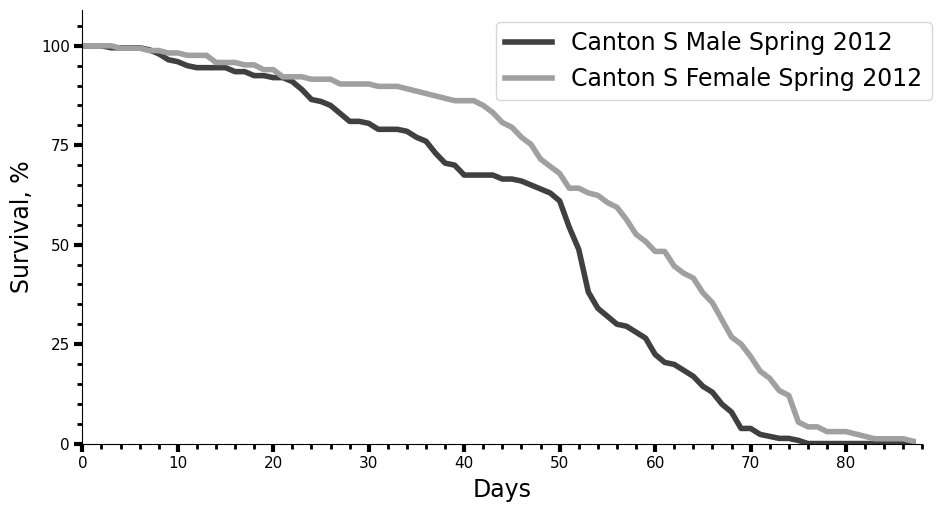

In [ ]:
for allele in genotype_names:
    for pair in SAMPLES:
        print (allele, pair)
        draw_survival_only(allele, pair)

# Survival curves + bars

Genotype Canton S Male Spring 2012, Canton S Female Spring 2012


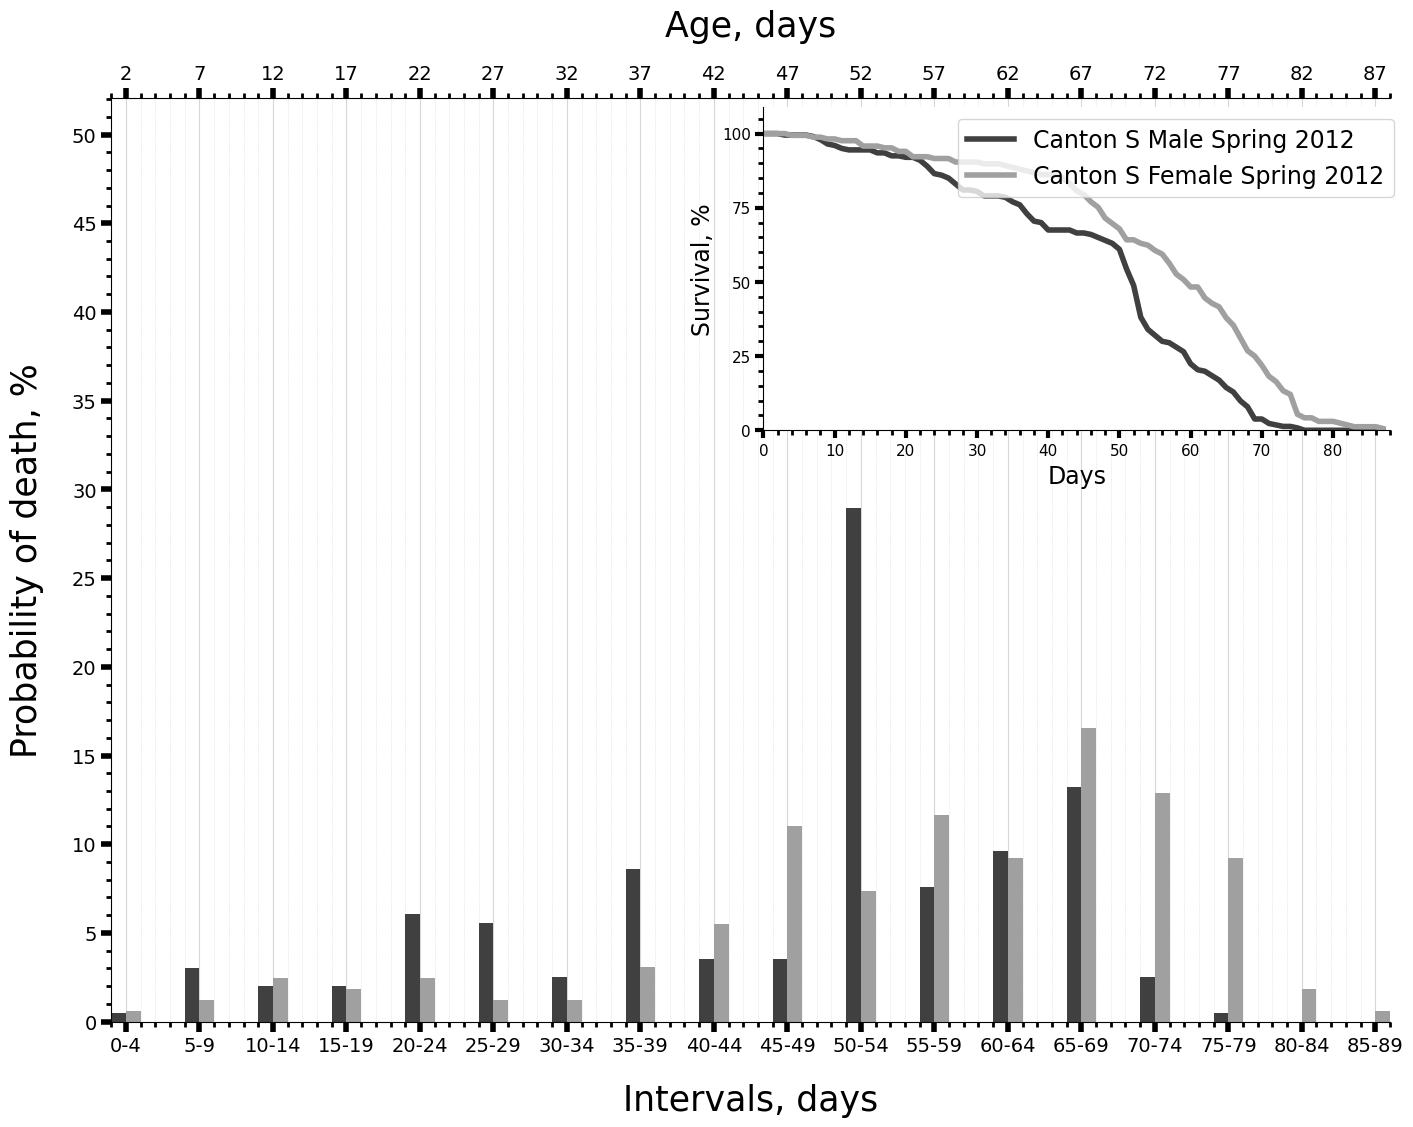

In [ ]:
parameters = default_settings()
for allele in genotype_names:
    for pair in SAMPLES:
        print (allele, pair)
        draw_plot(allele, pair, ls_data, raw_data, parameters[0])

# Survival curves + bars + SW test

Genotype Canton S Male Spring 2012, Canton S Female Spring 2012


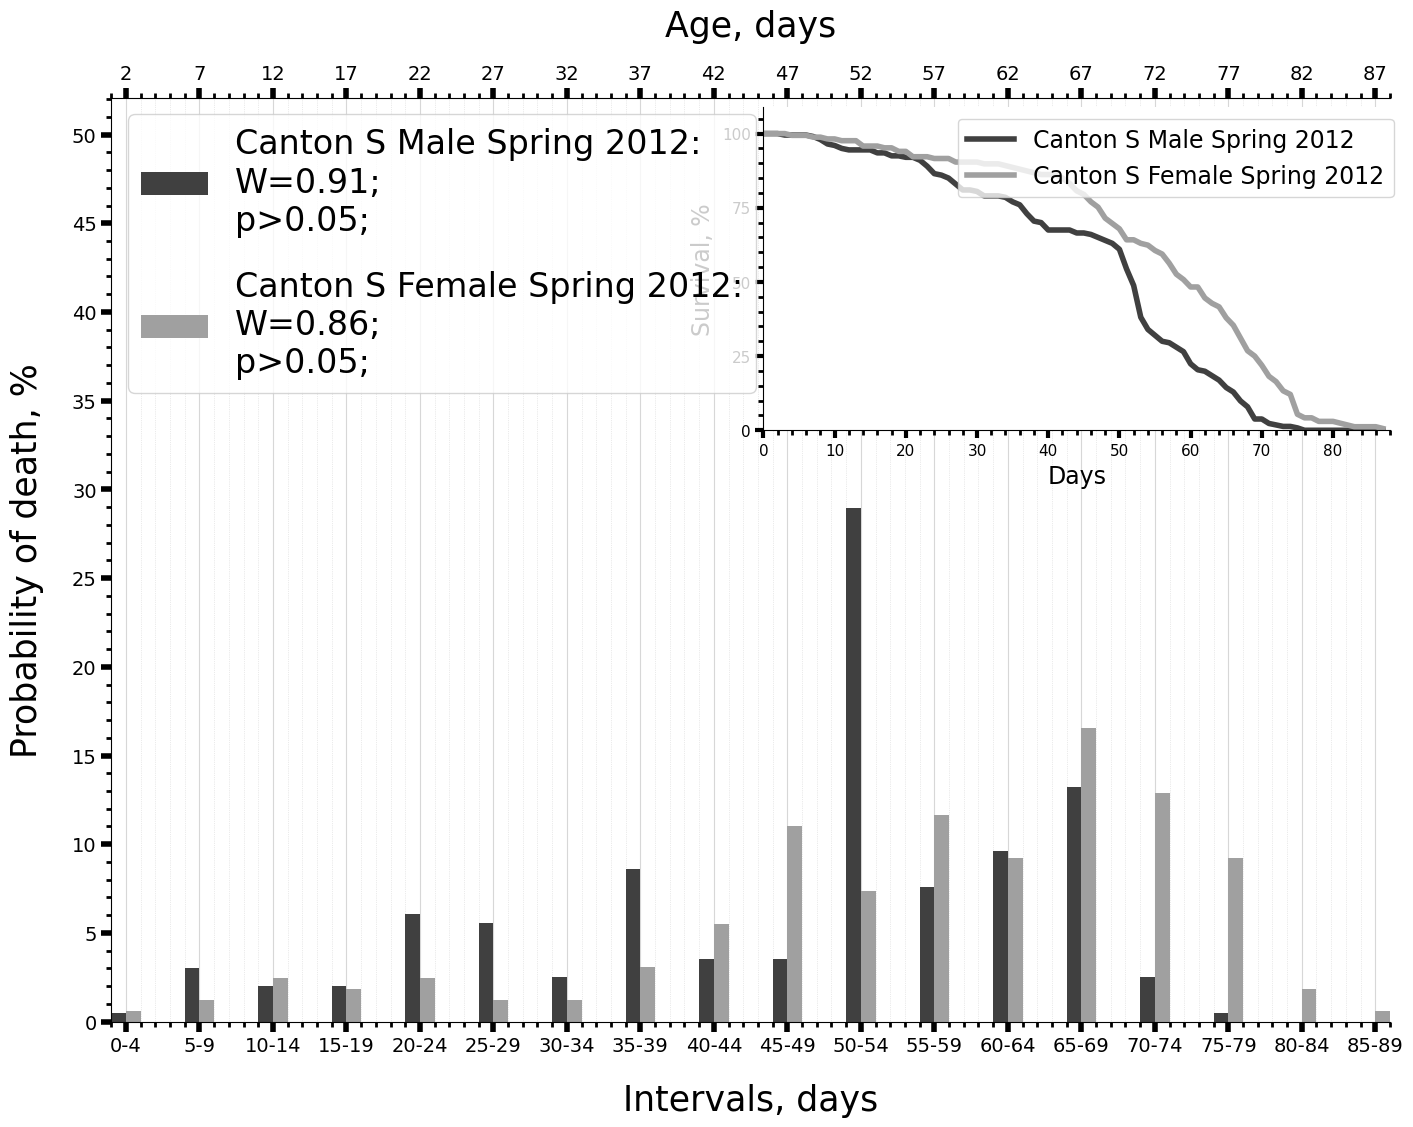

In [ ]:
parameters = default_settings()
for allele in genotype_names:
    for pair in SAMPLES:
        print (allele, pair)
        draw_plot(allele, pair, ls_data, raw_data, parameters[1])

# Survival curves + bars + SW test + normal distribution

In [ ]:
parameters = default_settings()
for allele in genotype_names:
    for pair in SAMPLES:
        print (allele, pair)
        draw_plot(allele, pair, ls_data, raw_data, parameters[2])

# Survival curves + bars + SW test + beta-distribution

In [ ]:
parameters = default_settings()
for allele in genotype_names:
    for pair in SAMPLES:
        print (allele, pair)
        draw_plot(allele, pair, ls_data, raw_data, parameters[3])

# Survival curves + bars + SW test + normal distribution (for control) + ideal normal distribution (for control)

In [ ]:
parameters = default_settings()
for allele in genotype_names:
    for pair in SAMPLES:
        print (allele, pair)
        draw_plot(allele, pair, ls_data, raw_data, parameters[4])

# Survival curves + bars + SW test + normal distribution (for mutant) + ideal normal distribution (for mutant)

In [ ]:
parameters = default_settings()
for allele in genotype_names:
    for pair in SAMPLES:
        print (allele, pair)
        draw_plot(allele, pair, ls_data, raw_data, parameters[5])

# **Graphs for beta-distribution manual selection** (using mode, median, intervalized and original sample series)

In [ ]:
def beta_distribution_comparison(allele, pair, ls_data, raw_data, parameter):
    pair_data = prepare_pair_data(allele, pair, ls_data, raw_data)

    colours = ['#1f77b4', '#d62728']  #colors of the lines control/mutant

    linestyle_one_sample = ["-","--","-.",":"]

    curves = []

    for idx in range(len(pair_data["names"])):
        name = pair_data["names"][idx]

        bars_counts = pair_data["bars_counts"][idx]
        bars_pct    = pair_data["bars_pct"][idx]
        lifespan    = pair_data["lifespan"][idx]

        start_i = FIND_START(bars_counts)
        end_i   = FIND_END(bars_counts)
        x_start = pair_data["x_main"][start_i]
        x_end   = pair_data["x_main"][end_i]

        # different methods
        linestyle_multiplier = 0
        for intnon in ["INT", "NONINT"]:
            for pq in ["MODE", "MEDIAN"]:
                sample = "Control" if idx == 0 else "Mutant"
                intnon_label = "int." if intnon == "INT" else "ori."
                pq_label = "mode" if pq == "MODE" else "median"
                linestyle = linestyle_one_sample[linestyle_multiplier]

                beta_plot, medmod = prepare_beta_curve(
                    intnon,
                    pq,
                    parameter["methods"]["Initial_day"][idx],
                    bars_counts,
                    lifespan,
                    parameter["methods"]["beta_step"]
                )

                beta_plot = beta_plot * max(bars_pct) / max(beta_plot)

                curves.append({
                    "x_start": x_start,
                    "x_end":   x_end,
                    "y":       beta_plot,
                    "color":   colours[idx],
                    "label_line":   f"{name} {intnon_label}series {pq_label}; {medmod.split(';')[0]}; {parameter['methods']['Initial_day'][idx]}",
                    "linestyle": linestyle
                })
                linestyle_multiplier+=1


    draw_plot(
        allele,
        pair,
        ls_data,
        raw_data,
        parameter,
        curves=curves,
        pair_data=pair_data,
        colours=colours,
        comparison=True
    )


#each graph = different initial day
parameters = []
for i in range(5):
  parameters.append (make_config(
          lines={"type": "beta"},
          methods={"Initial_day": [i, i]},
          show={"sub": False}
      ))

#making graphs
for allele in genotype_names:
  for pair in SAMPLES:
    for parameter in parameters:
            print (allele, pair, parameter["lines"])
            beta_distribution_comparison(allele, pair, ls_data, raw_data, parameter)

---
# **SW and KS tests comparison on non-intervalised (original) and intervalised series.**

In [ ]:
with open(f'Normality SW and KS test.txt', 'w') as f:
    f.writelines('\tSW-test\t\t\t\tKS-test\t\t\t\n')
    f.writelines('\tnon-intervalized\t\tintervalized\t\tnon-intervalized\t\tintervalized\n')
    f.writelines('\tW\tp-value\tW\tp-value\tDn\tp-value\tDn\tp-value\n')

    for allele in genotype_names:
        f.writelines(f"{allele}\n")
        sample_keys = [k for k in ls_data.keys() if k.startswith(allele.lower() + '\n')]

        for key in sample_keys:
            lifespan = ls_data[key]
            sample_name = key.split('\n')[1]

            intervalized_data = Sample_to_intervals(lifespan, delta=delta, i=-1)
            intervalized_data_ = cut_first_zero(intervalized_data)

            no_interval_SW = Shapiro_Wilk_normality_test_Royston(lifespan)
            interval_SW = Shapiro_Wilk_normality_test(intervalized_data_, a=table_for_a[str(len(intervalized_data_))])
            no_interval_KS = one_sample_KS_test(lifespan, asim=True)
            interval_KS = one_sample_KS_test(intervalized_data_, asim=False)

            results = (
            no_interval_SW.result(numeric=True)
            + interval_SW.result(numeric=True)
            + no_interval_KS.result(numeric=True)
            + interval_KS.result(numeric=True)
            )

            formatted = []
            for idx, val in enumerate(results):
                if idx % 2 == 1:
                    formatted.append(f"{val}")
                else:
                    formatted.append(f"{val:.2f}")

            f.writelines(sample_name.replace("\n", " ") + '\t' + "\t".join(formatted) + '\n')

        f.writelines(f"\n")

In [ ]:
with open('Normality SW test intervalised STURGES.txt', 'w') as f:
    # HEADERS
    f.writelines("A Shapiro-Wilk test, performed on the lifespan data divided into intervals according to Sturges's rule\n")
    f.writelines(
        "Sample name\t" +
        "Number of flies\t" +
        "Maximum lifespan\t" +
        "SW test statistics\t" +
        "p-value\tConclusion\t" +
        "Sturges's rule number of intervals\t" +
        "Sturges's rule width of the intervals\t" +
        "Number of intervals equalized between samples\t" +
        "Final width of the intervals\t\t" +
        "Intervalised data\n"
    )

    for allele in genotype_names:
        f.writelines("\t"*11+"\t".join(np.arange(1, 20).astype(str))+"\n")
        f.writelines(f"{allele}\n")
        for pair in SAMPLES:

            samples = pair.split(', ')
            lifespans = [ls_data[allele.lower() + '\n' + sample] for sample in samples]

            nofis = [STURGES(len(lifespan)) for lifespan in lifespans]
            nofi_paired = min(nofis)

            pair_intervalized_data = [Sample_to_intervals(lifespan, interv=nofi_paired, i=-1) for lifespan in lifespans]

            if np.all(pair_intervalized_data[0] == 0):
                pair_intervalized_data = cut_first_zero_multiple(pair_intervalized_data)

            for idx, lifespan in enumerate(lifespans):

                interval_width_s = (max(lifespan)+1)/nofis[idx]
                interval_width_eq = (max(lifespan)+1)/nofi_paired

                intervalized_data = pair_intervalized_data[idx]
                W, P = Shapiro_Wilk_normality_test(intervalized_data.copy(), table_for_a[str(len(intervalized_data))]).result(numeric=True)

                f.writelines(
                    f"{samples[idx]}\t"
                    f"{len(lifespan)}\t"
                    f"{max(lifespan)}\t"
                    f"{W:.2f}\t{format_p(P)}\t{conclusion(P)}\t"
                    f"{nofis[idx]:.2f}\t" + f"{interval_width_s:.2f}\t"
                    f"{len(intervalized_data)}\t" + f"{interval_width_eq:.2f}\t\t" +
                    "\t".join(str(x) for x in intervalized_data) +
                    "\n"
                )
        f.writelines(f"\n")


In [ ]:
with open('Normality SW test intervalised 5 DAYS.txt', 'w') as f:
    f.writelines("A Shapiro-Wilk test, performed on lifespan data divided into 5-day intervals\n")
    f.writelines(
        "Sample name\t" +
        "Number of flies\t" +
        "Maximum lifespan\t" +
        "SW test statistics\t" +
        "p-value\tConclusion\t" +
        "Width of the intervals\t" +
        "Number of intervals\t\t" +
        "Intervalised data\n"
    )

    intervals = define_sp(5, 20)
    intervals_ = [0]+[i+1 for i in intervals[:-2]]
    species = [str(i)+'..'+str(j) for i, j in zip(intervals_, intervals)]

    for allele in genotype_names:
        f.writelines(f"\t"*9 + "\t".join(species)+ "\n")
        f.writelines(f"{allele}\n")
        sample_keys = [k for k in ls_data.keys() if k.startswith(allele.lower() + '\n')]

        for key in sample_keys:
            lifespan = ls_data[key]
            sample_name = key.split('\n')[1]

            intervalized_data = Sample_to_intervals(lifespan, delta=delta, i=-1)
            intervalized_data_ = cut_first_zero(intervalized_data)
            W, P = Shapiro_Wilk_normality_test(intervalized_data_.copy(), table_for_a[str(len(intervalized_data_))]).result(numeric=True)

            f.writelines(
                f"{sample_name}\t"
                f"{len(lifespan)}\t"
                f"{max(lifespan)}\t"
                f"{W:.2f}\t{format_p(P)}\t{conclusion(P)}\t"
                f"{delta}\t" + f"{len(intervalized_data_)}\t\t" +
                "\t".join(str(x) for x in intervalized_data_) +
                "\n"
            )
        f.writelines(f"\n")

---
# **ADVANCED SETTINGS** for making custom graphs

In [ ]:
# # AUTO MODE
# parameters = default_settings()

# # MANUAL MODE
# mode1 = make_config(show={"...": False})
# mode2 = make_config(methods={"...": ["...","..."]})
# parameters = [mode1, mode2, ...]

# #CUSTOM GRAPHS
# for allele in genotype_names:
#     for pair in SAMPLES:
#         for parameter in parameters
#             print (allele, pair)
#             draw_plot(allele, pair, ls_data, raw_data, parameter)